In [ ]:
#| default_exp conditional_generator

In [ ]:
#| hide
import sys; sys.path.insert(0, '..') # make sure rust binary can be found...

In [ ]:
#| export
import warnings

import jax
import jax.numpy as jnp
import numpy as np
from inverse_design.design import (
    TOUCH_FREE,
    TOUCH_RESOLVING,
    TOUCH_VALID,
    UNASSIGNED,
    Design,
    add_solid_touch,
    add_void_touch,
    design_mask,
    new_design,
    take_free_solid_touches,
    take_free_void_touches,
)
from inverse_design.utils import argmax2d, argmin2d, conv2d, randn

In [ ]:
#| include: false
import matplotlib.pyplot as plt
from inverse_design.brushes import circular_brush, notched_square_brush, show_mask

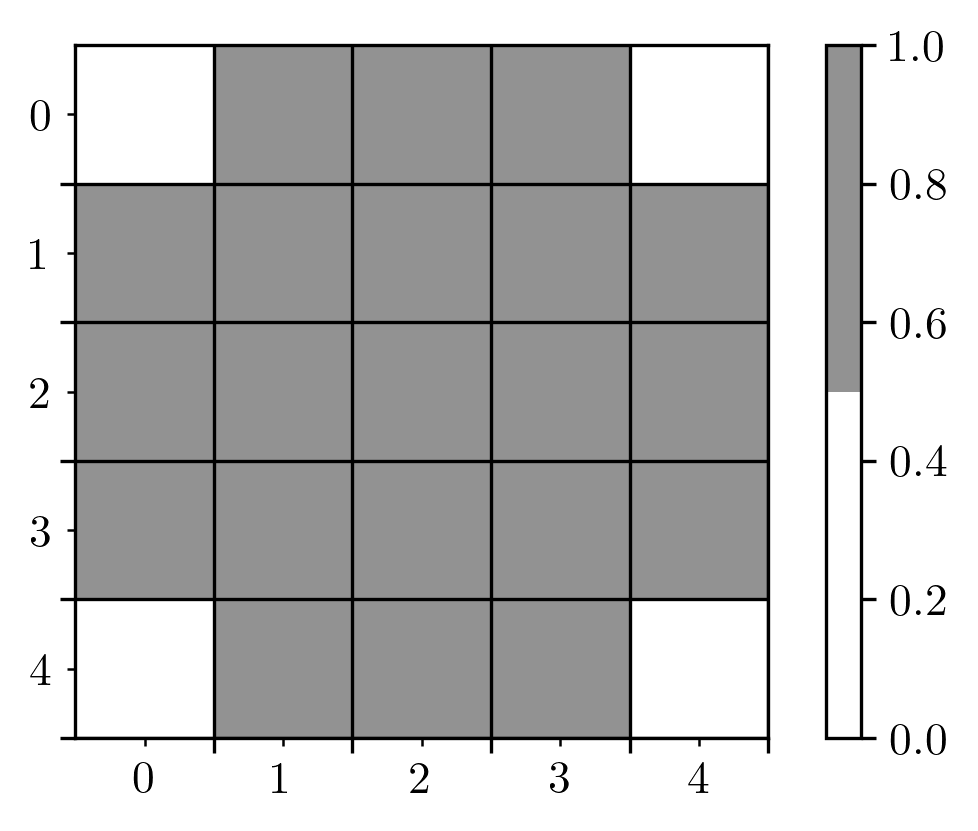

In [ ]:

my_brush = circular_brush(7)
my_brush = notched_square_brush(5, 1)
show_mask(my_brush)

## Latent Design
It's not very well explained in the paper what the latent design actually is. In this case we'll just assume it's an array of the same shape as the design, but with continuous values between 0 and 1.

In [ ]:
#| export
def new_latent_design(shape, bias=0, r=None, r_scale=1):
    arr = randn(shape, r=r)*r_scale
    arr += bias
    return jnp.asarray(arr, dtype=float)

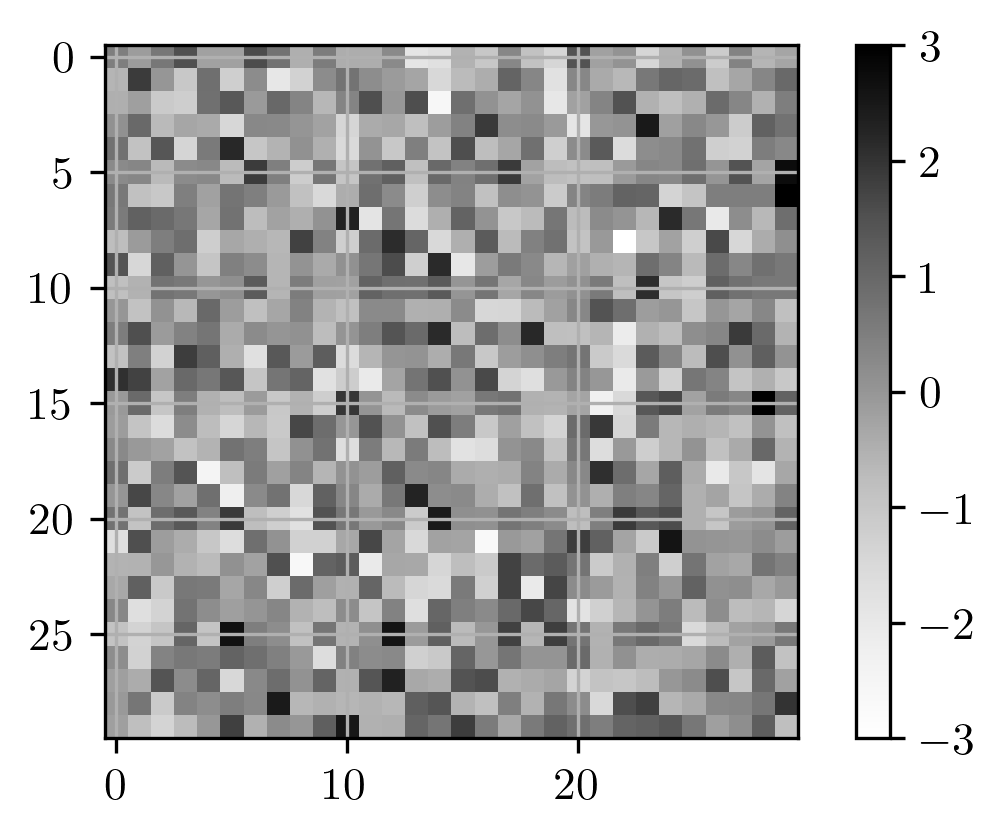

In [ ]:
seed=42
m,n = 30, 30
latent = new_latent_design((m,n), r=seed)
print(latent[:3, :3])
plt.imshow(latent, vmin=-3, vmax=3, cmap="Greys")
plt.colorbar()
plt.show()

In [ ]:
#with open(f"latent{seed}_{m}x{n}.bin", "wb") as file:
#    file.write(latent.tobytes())

## Transform
The transform removes some of the noise from the latent design.  

In [ ]:
#| export
@jax.jit
def transform(latent, brush, beta=5.0):
    convolved = conv2d(latent, jnp.asarray(brush, dtype=float)) / brush.sum()
    return jnp.tanh(beta * convolved)

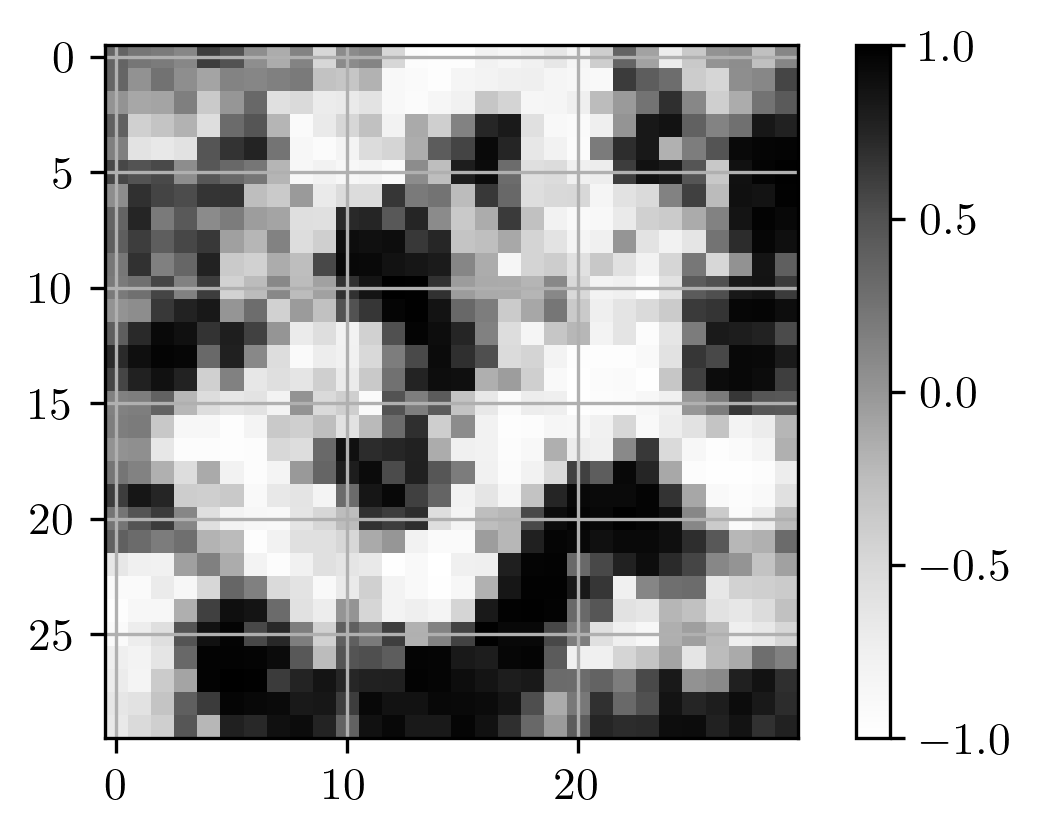

In [ ]:
latent_t = transform(latent, my_brush)
print(latent_t[:3, :3])
plt.imshow(latent_t, cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

## Conditional Generator

In [ ]:
#| export
def conditional_algirithm_step(latent_t, design, brush, verbose=False):
    maybe_print = print if verbose else (lambda *args, **kwargs: None)
    void_touch_mask = design.void_touches == TOUCH_VALID
    solid_touch_mask = design.solid_touches == TOUCH_VALID
    touch_mask = void_touch_mask | solid_touch_mask

    void_free_mask = design.void_touches == TOUCH_FREE
    solid_free_mask = design.solid_touches == TOUCH_FREE
    free_mask = void_free_mask | solid_free_mask

    void_resolving_mask = design.void_touches == TOUCH_RESOLVING
    solid_resolving_mask = design.solid_touches == TOUCH_RESOLVING
    resolving_mask = void_resolving_mask | solid_resolving_mask

    if free_mask.any():
        void_selector = jnp.where(void_free_mask, latent_t, 0)
        solid_selector = jnp.where(solid_free_mask, latent_t, 0)
        if abs(void_selector.sum()) > abs(solid_selector.sum()):
            design = take_free_void_touches(design, brush)
            maybe_print(f"take free void.")
        else:
            design = take_free_solid_touches(design, brush)
            maybe_print(f"take free solid.")

    elif resolving_mask.any():
        void_needs_resolving = void_resolving_mask.any()
        solid_needs_resolving = solid_resolving_mask.any()
        void_selector = jnp.where(void_resolving_mask, latent_t, np.inf)
        solid_selector = jnp.where(solid_resolving_mask, latent_t, -np.inf)

        if void_needs_resolving and (not solid_needs_resolving):
            i_v, j_v = argmin2d(void_selector)
            design = add_void_touch(design, brush, (i_v, j_v))
            maybe_print(f"resolve void {int(i_v), int(j_v)}.")
        elif (not void_needs_resolving) and solid_needs_resolving:
            i_s, j_s = argmax2d(solid_selector)
            design = add_solid_touch(design, brush, (i_s, j_s))
            maybe_print(f"resolve solid {int(i_s), int(j_s)}.")
        else:  # both need resolving. TODO: figure out if we actually need this case...
            i_v, j_v = argmin2d(void_selector)
            v = latent_t[i_v, j_v]
            i_s, j_s = argmax2d(solid_selector)
            s = latent_t[i_s, j_s]
            if abs(v) > abs(s):
                design = add_void_touch(design, brush, (i_v, j_v))
                maybe_print(f"resolve void {int(i_v), int(j_v)}.")
            else:
                design = add_solid_touch(design, brush, (i_s, j_s))
                maybe_print(f"resolve solid {int(i_s), int(j_s)}.")

    elif touch_mask.any():
        void_selector = jnp.where(void_touch_mask, latent_t, np.inf)
        solid_selector = jnp.where(solid_touch_mask, latent_t, -np.inf)
        i_v, j_v = argmin2d(void_selector)
        v = latent_t[i_v, j_v]
        i_s, j_s = argmax2d(solid_selector)
        s = latent_t[i_s, j_s]
        if abs(v) > abs(s):
            design = add_void_touch(design, brush, (i_v, j_v))
            maybe_print(f"touch void {int(i_v), int(j_v)}.")
        else:
            design = add_solid_touch(design, brush, (i_s, j_s))
            maybe_print(f"touch solid {int(i_s), int(j_s)}.")
    else:
        raise ValueError("This should never happen.")

    return design

In [ ]:
#| export
def conditional_generator(latent_t, brush, verbose=False):
    I = 0
    design = new_design(latent_t.shape)
    maybe_print = print if verbose else (lambda *args, **kwargs: None)
    maybe_print(f"create empty design.")
    yield design
    while (design.design == UNASSIGNED).any():
        maybe_print(f"iteration {I}")
        I += 1
        design = conditional_algirithm_step(latent_t, design, brush, verbose=verbose)
        yield design

In [ ]:
#| export

def generate_feasible_design(latent_t, brush, verbose=False, backend='auto'): # backend: 'auto', 'rust', 'python'
    try:
        from inverse_design_rs import generate_feasible_design as generate_feasible_design_rs
        if backend == 'auto':
            backend = 'rust'
    except ImportError:
        warnings.warn("falling back on slower python-based feasible design generation!")
        if backend == 'auto':
            backend = 'python'
            
    if backend == 'rust':
        return _generate_feasible_design_rust(latent_t, brush, verbose=verbose)
    else:
        return _generate_feasible_design_python(latent_t, brush, verbose=verbose)
        

def _generate_feasible_design_python(latent_t, brush, verbose=False):
    design = None
    for design in conditional_generator(latent_t, brush, verbose=verbose):
        continue
    return design

def _generate_feasible_design_rust(latent_t, brush, verbose=False):
    from inverse_design_rs import generate_feasible_design as generate_feasible_design_rs
    m, n = latent_t.shape

    brush = np.asarray(brush, dtype=np.float32)
    latent_t = np.asarray(latent_t, dtype=np.float32)

    void, void_touch_existing, solid_touch_existing = generate_feasible_design_rs(
        latent_t.shape,
        latent_t.tobytes(),
        brush.shape,
        brush.tobytes(),
        verbose,
    )
    void = np.asarray(void).reshape(m, n)
    void_touch_existing = np.asarray(void_touch_existing).reshape(m, n)
    solid_touch_existing = np.asarray(solid_touch_existing).reshape(m, n)

    void_pixels = np.asarray(np.where(void, 4, 3), dtype=np.uint8)
    solid_pixels = np.asarray(np.where(void, 3, 4), dtype=np.uint8)
    void_touches = np.asarray(np.where(void_touch_existing, 9, 8), dtype=np.uint8)
    solid_touches = np.asarray(np.where(solid_touch_existing, 9, 8), dtype=np.uint8)

    design = Design(
        np.asarray(void_pixels).reshape(m, n),
        np.asarray(solid_pixels).reshape(m, n),
        np.asarray(void_touches).reshape(m, n),
        np.asarray(solid_touches).reshape(m, n),
    )
    return design

Design(void_pixels=Array([[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 3, 3, 3, 3],
       [3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
        3, 3, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 4, 4],
       [3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4

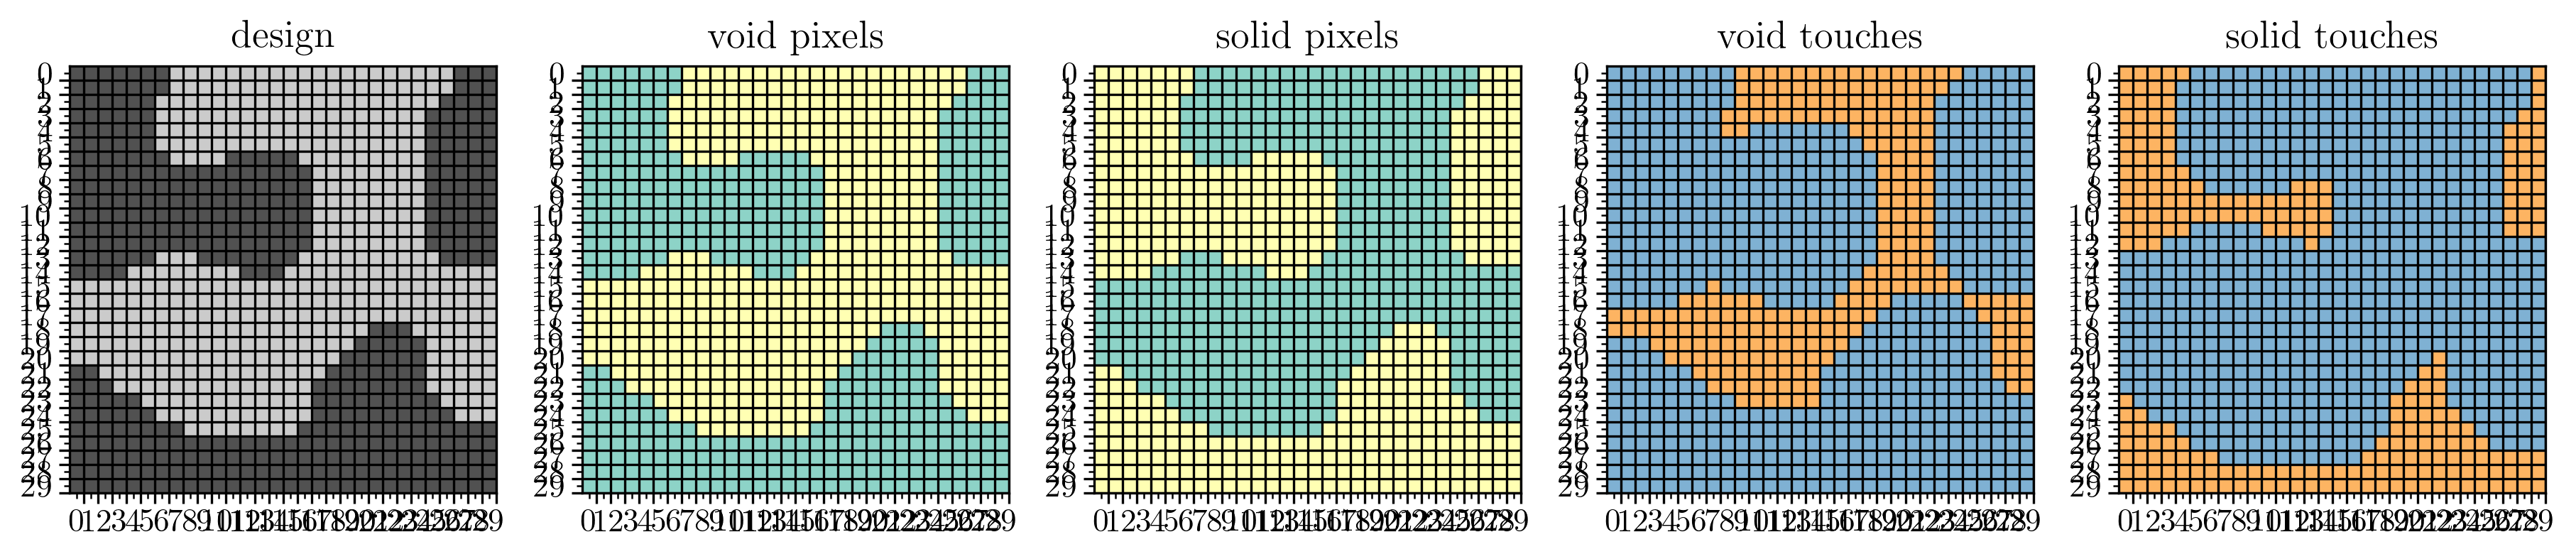

In [ ]:
%time my_design = generate_feasible_design(latent_t, my_brush, verbose=False)
my_design

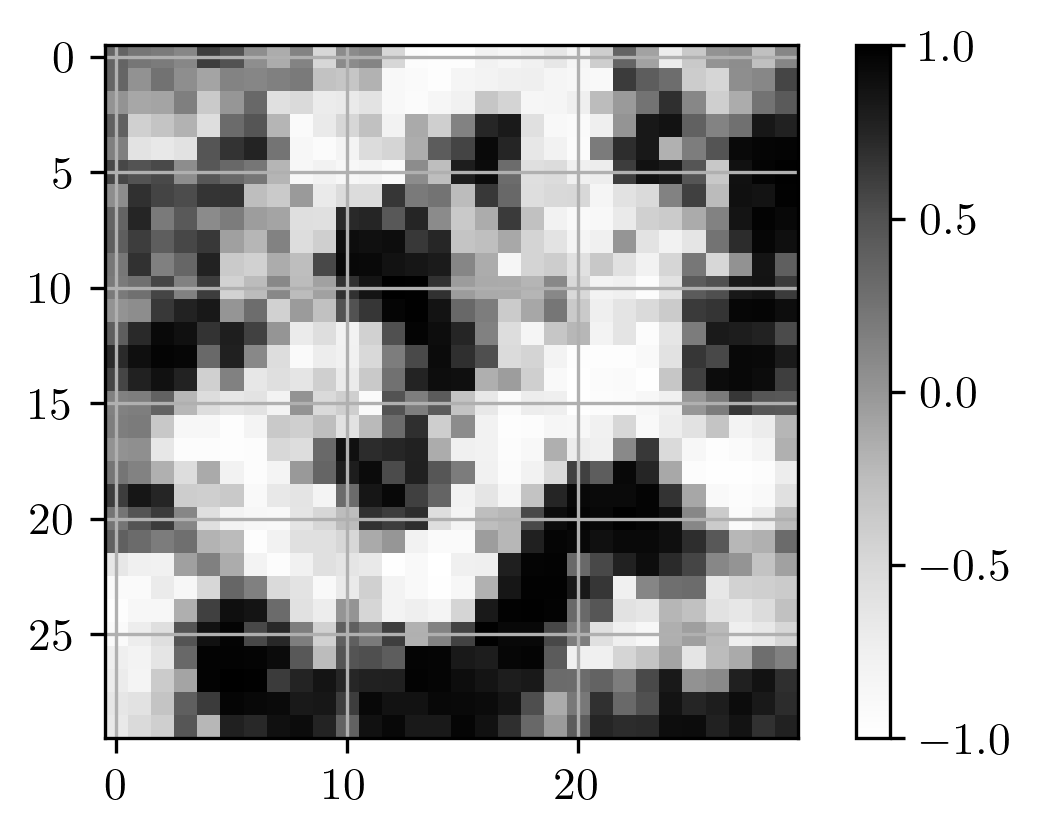

In [ ]:
latent_t = transform(latent, my_brush)
plt.imshow(latent_t, cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In practice however, it's probably more useful to generate a design *mask* straight away (+1.0 for solid, -1.0 for void):

In [ ]:
#| export
def generate_feasible_design_mask_(latent_t, brush, backend='auto'):
    design = generate_feasible_design(latent_t, brush, verbose=False, backend=backend)
    return design_mask(design)

In [ ]:
my_design_mask = generate_feasible_design_mask_(latent_t, my_brush)
my_design_mask.shape

(30, 30)

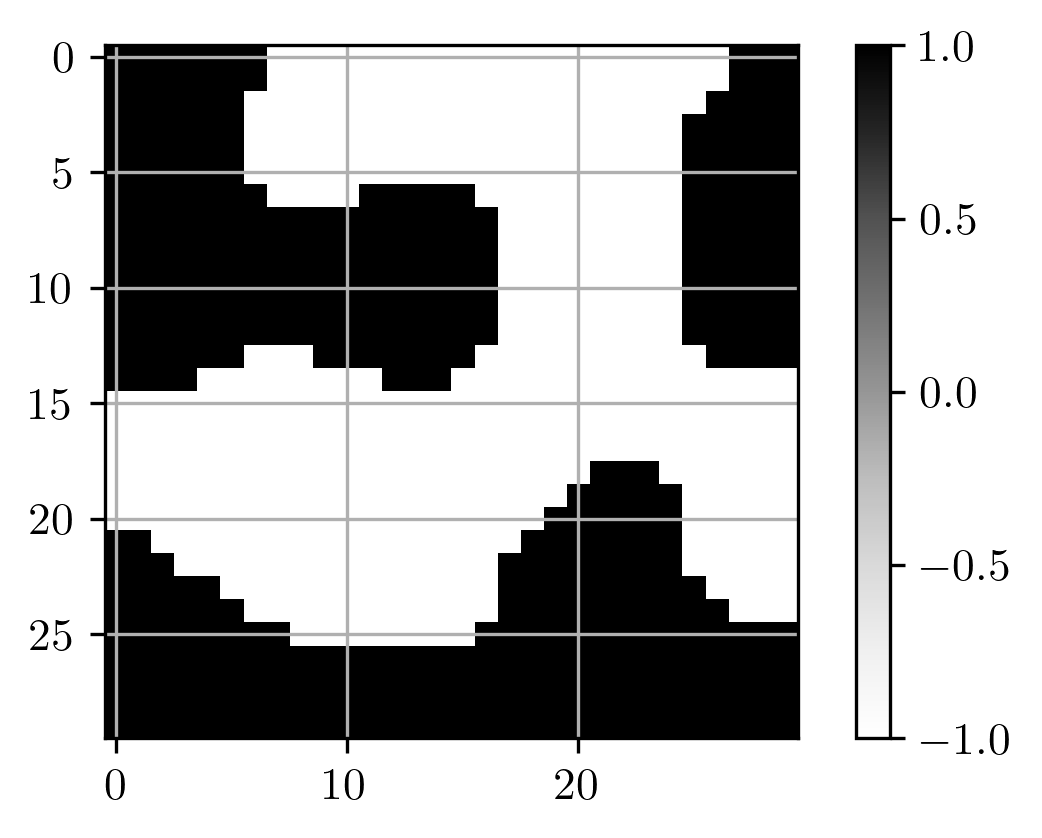

In [ ]:
plt.imshow(my_design_mask, cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

## Straight Through Estimator

We cannot just call `jax.grad` on our feasible design mask generator. All gradients will be zero as our mask generator is not differentiable...

In [ ]:
def my_test_loss_function_(latent_t, brush):
    return generate_feasible_design_mask_(latent_t, brush, backend='python').mean()

In [ ]:
g = jax.grad(my_test_loss_function_)
assert (g(latent_t, my_brush) == 0).all()

Moreover, if we would have chosen the Rust-based backend, the above cell would have errored out...

In stead, we use a straight-through estimator (a.k.a. identity function) for our feasible design:

In [ ]:
#| export
@jax.custom_jvp
def generate_feasible_design_mask(latent_t, brush):
    design = generate_feasible_design(latent_t, brush, verbose=False)
    return design_mask(design)

In [ ]:
#| export
@generate_feasible_design_mask.defjvp
def generate_feasible_design_mask_jvp(primals, tangents):
    return primals[0], tangents[0]  # identity function for first argument: latent_t

In [ ]:
def my_test_loss_function(latent_t, brush):
    return generate_feasible_design_mask(latent_t, brush).mean()

In [ ]:
g = jax.grad(my_test_loss_function)
assert (g(latent_t, my_brush) != 0).any()